### Def

In [1]:
%run '../definitions.ipynb'
%run 'XAMSraw.ipynb'

In [2]:
# All cold datasets, perhaps the last one suffers from Rn? Have to check warm datasets?
datasets = [
  [
    # Ch 0 (900 V)
    # '170313_101924' # warm
    '170313_101924',
    '170323_103732',
    '170327_143657',
    '170404_114542'
  ],
  [
    # Ch 1 (850 V)
    # '170313_102507' # warm
    '170313_102507',
    '170323_104831',
    '170327_144150',
    '170404_115739'
  ]
]

# gain by channel
gains = [2379128.143411107, 2561006.625638467]


# Just one channel

### Settings

In [3]:
# Warm data
# dset900 = '170313_101924'
# dset850 = '170313_102507'

# Just before data
dset900 = '170323_103732'
dset850 = '170323_104831'

# Just after data (baseline issues?)
# dset900 = '170327_143657'
# dset850 = '170327_144150'

# Latest data (PMT2 has lots of ringing)
# dset900 = '170404_114542'
# dset850 = '170404_115739'

gain_900_0 = 2379128.143411107
gain_850_1 = 2561006.625638467

In [4]:
# Settings channel 0
begrenzer = 1000
dset = dset900
gain = gain_900_0
channel = 0

baseline_left = (275, 325)
baseline_right =(400, 450)
area_bounds = (325, 375)
area_cut_bounds = (0.5, 3)
noise_max = 7
min_amplitude = 35

In [75]:
# Settings channel 1
begrenzer = 1000
dset = dset850
gain = gain_850_1
channel = 1

baseline_left = (275, 325)
baseline_right =(400, 450)
area_bounds = (325, 375)
area_cut_bounds = (0.5, 3)
noise_max = 7
min_amplitude = 35

### Channel zero (PMT2)

In [76]:
x = XAMSRaw('/data/xenon/xams/run8/raw/pmtdata/', dset, channel,
            pickle_dir='/home/erik/win/data/xams_run8/single_e_waveforms')

In [77]:
x.process_all(begrenzer, baseline_left, baseline_right, area_bounds, gain)

100%|██████████| 1000/1000 [00:03<00:00, 321.89it/s]


In [78]:
x.load_processed(stop_after=begrenzer)

100%|██████████| 1000/1000 [00:11<00:00, 85.72it/s]


In [79]:
len(x.df)

1000000

### What is the 7 mV threshold?

In [80]:
2**14

16384

In [81]:
def gauss(x, mu, sigma):
    return np.exp(-(x - mu)**2 / (2 * sigma**2))

In [82]:
# Converting counts to voltage in mV
vs = x.df['max'] * 0.5 / (2**14) * 1000

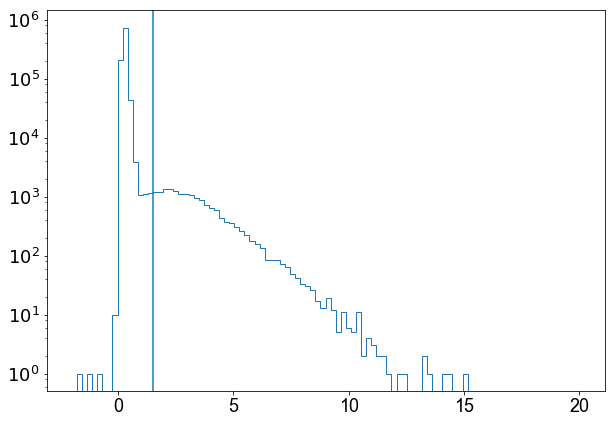

In [83]:
plt.hist(vs, bins=100, histtype='step', range=(-2, 20))
plt.yscale('log')
plt.axvline(1.5)
plt.show()

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/numpy/core/_methods.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return umr_maximum(a, axis, None, out, keepdims)


FCN = 89303.90843695367 
 TOTAL NCALL = 0 
 NCALLS = 59 
 
 
 EDM = 4.189274414787525e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,x0,0.887923,0.165271,0,0,,,
2,x1,2.52339,0.0633866,0,0,,,


(1, 100000.0)

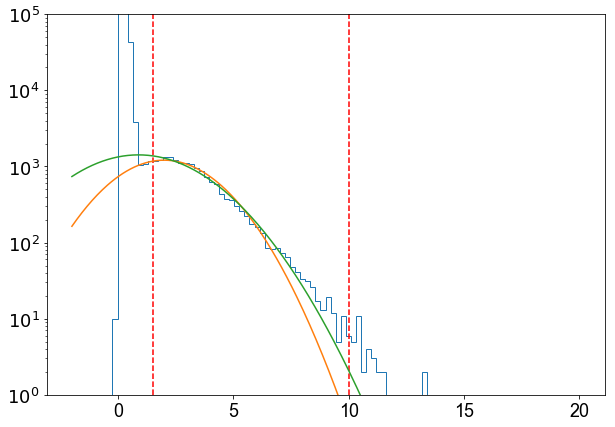

In [85]:
m = fit_unbinned(vs, gauss, [2, 2], fit_range=(1.5, 10), plot_range=(-2, 20), plot=True)
plt.yscale('log')
plt.ylim(1, 1e5)

In [86]:
popt = m[0]

In [87]:
def get_avg(popt):
    int_range = (0, 10)
    total      = scipy.integrate.quad(lambda x : gauss(x, *popt), *int_range)[0]
    avg_nonorm = scipy.integrate.quad(lambda x : x * gauss(x, *popt), *int_range)[0]
    return avg_nonorm / total

In [88]:
get_avg(popt)

2.370188327631698

How many times the average single p.e. level is the trigger of 7 mV?

In [89]:
7 / get_avg(popt)

2.953351815294116

Three times. Plus minus what?

In [90]:
popt = m[0]
perr = m[1]
bla = []
for p_sig in [-1, 0, 1]:
    for p_mu in [-1, 0, 1]:
        ptrial = [popt[0] +  p_mu * perr[0], popt[1] +  p_sig * perr[1]]
        bla.append(get_avg(ptrial))
        

In [91]:
print('The error on the average is %.2f percent.' % (100 * np.std(bla) / np.average(bla)))

The error on the average is 3.04 percent.


In [92]:
0.026 * 3

0.078

So 3.0 +- 0.1 (plus minus roughly 0.1), maybe a bit more given systematic errors.

#### Moving on...

In [70]:
x.cut_area(area_cut_bounds)

Selected 17136 of 1000000 events (1.71 %)


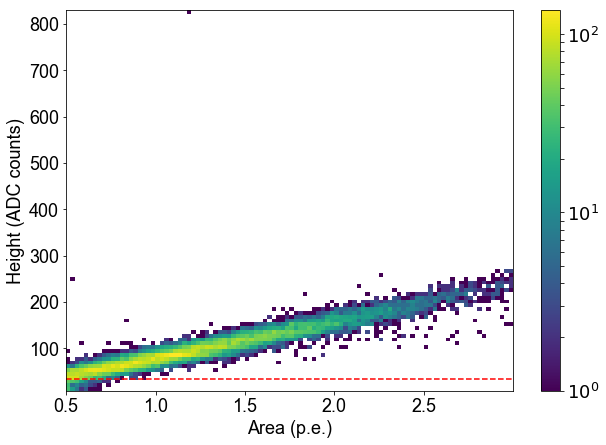

In [71]:
x.plot_area_height(min_amplitude, bins=100, norm=LogNorm())
plt.show()

In [72]:
x.cut_max((min_amplitude, 10000))

Selected 16781 of 17136 events (97.93 %)


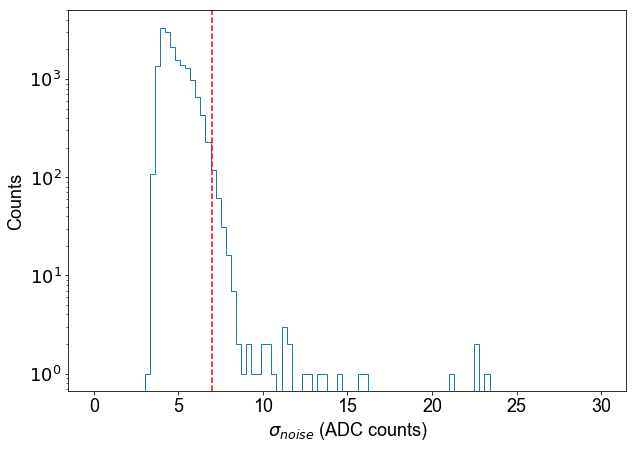

In [73]:
x.plot_noise(noise_max, bins=100, histtype='step', range=(0, 30))
plt.show()

In [74]:
x.cut_noise(noise_max)

Selected 16557 of 16781 events (98.67 %)


In [75]:
x.load_waveforms()
x.process(baseline_left, baseline_right, area_bounds, gain_900_0)

100%|██████████| 1000/1000 [00:53<00:00, 17.50it/s]


In [76]:
t, pulse = x.get_average_pulse()

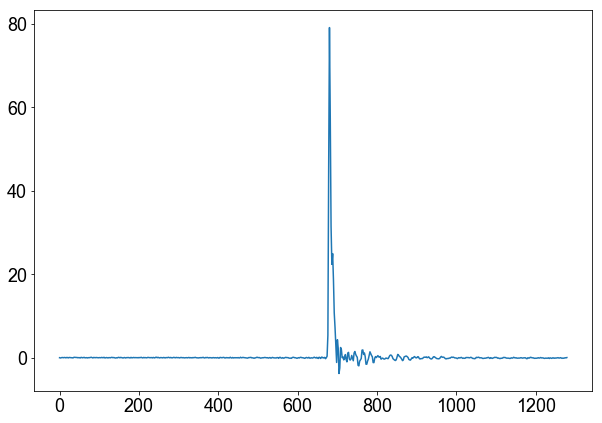

In [77]:
plt.plot(t, pulse)

### The single electron gain spread function

In [78]:
def gaus(x, mu, sigma):
    return np.exp( - (x - mu)**2 / (2 * sigma**2))

def gaus_trunc(x, mu, sigma):
    return (x > 0) * np.exp( - (x - mu)**2 / (2 * sigma**2))

#### Channel 0

In [85]:
# Settings
begrenzer = 1000
dset = dset900
gain = gain_900_0
channel = 0

In [86]:
x = XAMSRaw('/data/xenon/xams/run8/raw/pmtdata/', dset, channel,
            pickle_dir='/home/erik/win/data/xams_run8/single_e_waveforms')
x.process_all(begrenzer, baseline_left, baseline_right, area_bounds, gain)
x.load_processed(stop_after=begrenzer)

100%|██████████| 1000/1000 [00:05<00:00, 181.09it/s]


(0, 1000)

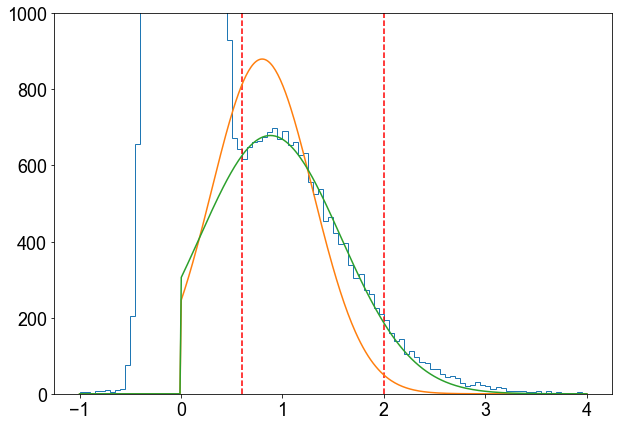

In [87]:
popt, perr, _ , _ = fit_unbinned(x.df['area'], gaus_trunc, (0.8,0.5), plot=True, fit_range=(0.6, 2.), 
                                plot_range=(-1, 4), print_level=0)
plt.ylim(0, 1000)

In [88]:
norm = integrate(gaus_trunc, popt, -1, 4, 1000)
def to_int(x, mu, sigma):
    return x * gaus_trunc(x, mu, sigma)
intxfdx = integrate(to_int, popt, -1, 4, 1000)
print('Gain ratio: ', intxfdx / norm)

Gain ratio:  1.01955116473


In [89]:
pickle.dump((norm, popt, perr), open(x.run_name + '_ch%d_function.pickle' % x.channel, 'wb'))

#### Channel 1

In [90]:
# Settings
begrenzer = 1000
dset = dset850
gain = gain_850_1
channel = 1

In [91]:
x = XAMSRaw('/data/xenon/xams/run8/raw/pmtdata/', dset, channel,
            pickle_dir='/home/erik/win/data/xams_run8/single_e_waveforms')
x.process_all(begrenzer, baseline_left, baseline_right, area_bounds, gain)
x.load_processed(stop_after=begrenzer)

100%|██████████| 1000/1000 [00:12<00:00, 77.37it/s]


(0, 1000)

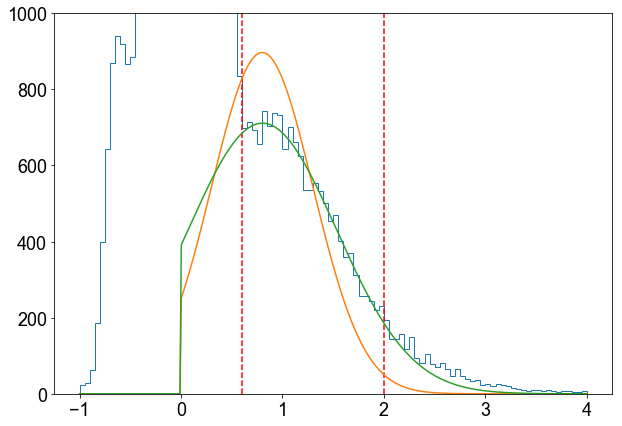

In [92]:
popt, perr, _ , _ = fit_unbinned(x.df['area'], gaus_trunc, (0.8,0.5), plot=True, fit_range=(0.6, 2.), 
                                plot_range=(-1, 4), print_level=0)
plt.ylim(0, 1000)

In [95]:
norm = integrate(gaus_trunc, popt, -1, 4, 1000)
def to_int(x, mu, sigma):
    return x * gaus_trunc(x, mu, sigma)
intxfdx = integrate(to_int, popt, -1, 4, 1000)
print('Gain ratio: ', intxfdx / norm)

Gain ratio:  0.986878711044


In [96]:
pickle.dump((norm, popt, perr), open(x.run_name + '_ch%d_function.pickle' % x.channel, 'wb'))

# Dump the average pulse

### Compute average pulse for all datasets and channels

#### Definition of main function

In [118]:
def load_all(dset, channel, gain, area_bounds, area_cut_bounds,
             baseline_left, baseline_right, stop_after = 1000, plot = False):
    x = XAMSRaw('/data/xenon/xams/run8/raw/pmtdata/', dset, channel,
            pickle_dir='/home/erik/win/data/xams_run8/single_e_waveforms/')
    x.process_all(stop_after, baseline_left, baseline_right, area_bounds, gain)
    x.load_processed(stop_after)
    # Cuts
    # Area
    if plot:
        x.plot_area_spectrum(area_bounds = area_cut_bounds, bins=100, histtype='step', range=(-0.5, 4))
        plt.show()
    x.cut_area(area_cut_bounds)
    # Heigth
    if plot:
        x.plot_area_height(min_amplitude, bins=100, norm=LogNorm())
        plt.show()
    x.cut_max((min_amplitude, 10000))
    # Noise
    if plot:
        x.plot_noise(noise_max, bins=100, histtype='step', range=(0, 30))
        plt.show()
    x.cut_noise(noise_max)
    
    # Load waveforms, process, and compute average
    x.load_waveforms()
    x.process(baseline_left, baseline_right, area_bounds, gain)
    t, pulse = x.get_average_pulse()
    
    pickle.dump(pulse, open('%s_ch%d.pickle' % (dset, channel) , 'wb'))
    return x, t, pulse

#### General settings

In [8]:
# Settings
baseline_left = (275, 325)
baseline_right =(400, 450)
area_bounds = (325, 375)
area_cut_bounds = (0.5, 3)
noise_max = 7
min_amplitude = 35

In [167]:
sure = False

if sure == True:
    for channel in [1]:
        gain = gains[channel]
        for dset in datasets[channel]:
            print(dset)
            _ = load_all(dset, channel, gain, area_bounds, area_cut_bounds,
                 baseline_left, baseline_right, stop_after = 1000, plot = False)


  0%|          | 0/1000 [00:00<?, ?it/s]

170313_102507



100%|██████████| 1000/1000 [00:10<00:00, 98.51it/s]


Selected 50198 of 1000000 events (5.02 %)


  0%|          | 0/1000 [00:00<?, ?it/s]

Selected 49776 of 50198 events (99.16 %)
Selected 48952 of 49776 events (98.34 %)


  0%|          | 0/1000 [00:00<?, ?it/s]

170323_104831


100%|██████████| 1000/1000 [00:17<00:00, 55.63it/s]


Selected 18272 of 1000000 events (1.83 %)
Selected 17270 of 18272 events (94.52 %)
Selected 16906 of 17270 events (97.89 %)


  0%|          | 0/1000 [00:00<?, ?it/s]

170327_144150


100%|██████████| 1000/1000 [00:16<00:00, 59.17it/s]


Selected 18753 of 1000000 events (1.88 %)


  0%|          | 1/1000 [00:00<01:59,  8.37it/s]

Selected 15640 of 18753 events (83.40 %)
Selected 15229 of 15640 events (97.37 %)


  0%|          | 0/1000 [00:00<?, ?it/s]

170404_115739


100%|██████████| 1000/1000 [00:33<00:00, 29.78it/s]


Selected 39091 of 1000000 events (3.91 %)


  0%|          | 0/1000 [00:00<?, ?it/s]

Selected 38527 of 39091 events (98.56 %)
Selected 38348 of 38527 events (99.54 %)


100%|██████████| 1000/1000 [01:07<00:00, 15.04it/s]


# Model building

### Read all average waveforms and compare

In [3]:
t = np.linspace(0, 639*2, 640)

#### Channel 0

In [4]:
channel = 0

In [5]:
# Read
pulses_ch0 = []
for dset in datasets[channel]:
    pulse = pickle.load(open('%s_ch%d.pickle' % (dset, channel) , 'rb'))
    pulses_ch0.append(pulse)

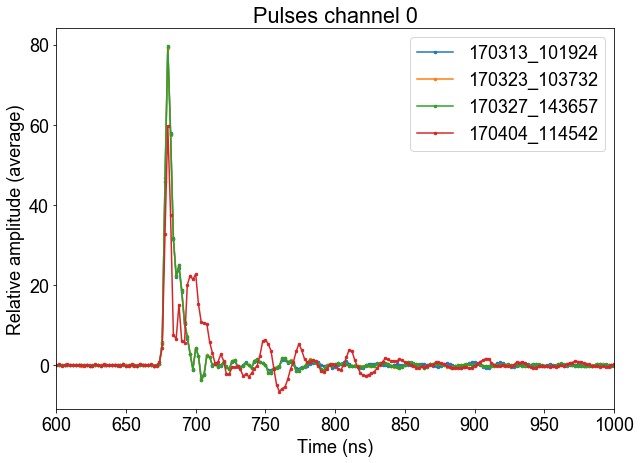

In [6]:
# Plot
for dset, pulse in zip(datasets[channel], pulses_ch0):
    plt.plot(t, pulse, label = dset, marker = '.', markersize = 5)
plt.xlabel('Time (ns)')
plt.ylabel('Relative amplitude (average)')
plt.xlim(600, 1000)
plt.title('Pulses channel %d' % channel)
plt.legend()
plt.show()

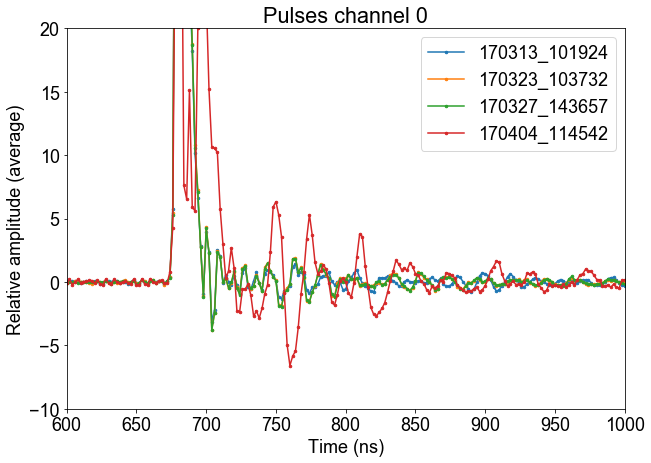

In [7]:
# Plot
for dset, pulse in zip(datasets[channel], pulses_ch0):
    plt.plot(t, pulse, label = dset, marker = '.', markersize = 5)
plt.xlabel('Time (ns)')
plt.ylabel('Relative amplitude (average)')
plt.xlim(600, 1000)
plt.ylim(-10, 20)
plt.title('Pulses channel %d' % channel)
plt.legend()
plt.show()

#### Channel 1

In [8]:
channel = 1

In [9]:
# Read
pulses_ch1 = []
for dset in datasets[channel]:
    pulse = pickle.load(open('%s_ch%d.pickle' % (dset, channel) , 'rb'))
    pulses_ch1.append(pulse)

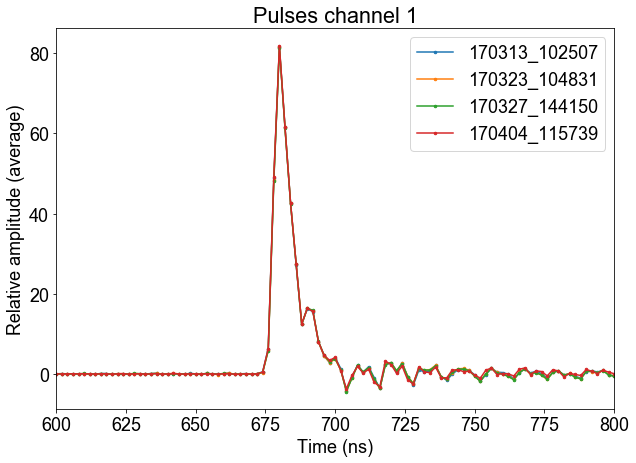

In [10]:
# Plot
for dset, pulse in zip(datasets[channel], pulses_ch1):
    plt.plot(t, pulse, label = dset, marker = '.', markersize = 5)
plt.xlabel('Time (ns)')
plt.ylabel('Relative amplitude (average)')
plt.xlim(600, 800)
plt.title('Pulses channel %d' % channel)
plt.legend()
plt.show()

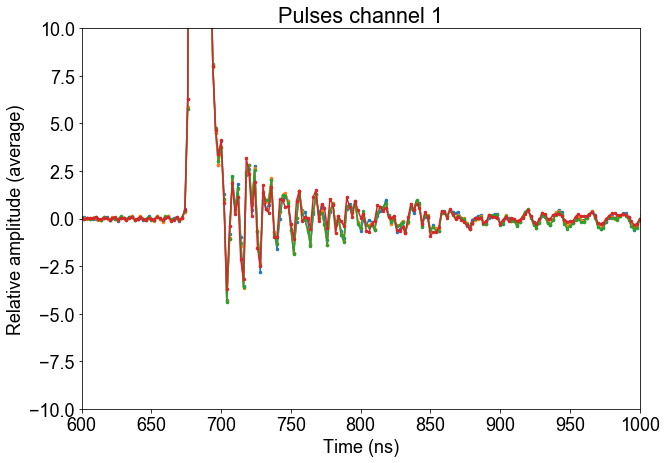

In [11]:
# Plot
for dset, pulse in zip(datasets[channel], pulses_ch1):
    plt.plot(t, pulse, label = dset, marker = '.', markersize = 5)
plt.xlabel('Time (ns)')
plt.ylabel('Relative amplitude (average)')
plt.xlim(600, 1000)
plt.ylim(-10, 10)
plt.title('Pulses channel %d' % channel)
plt.show()

In [12]:
pulse_ch0 = pulses_ch0[1]
pulse_ch1 = pulses_ch1[1]

(600, 800)

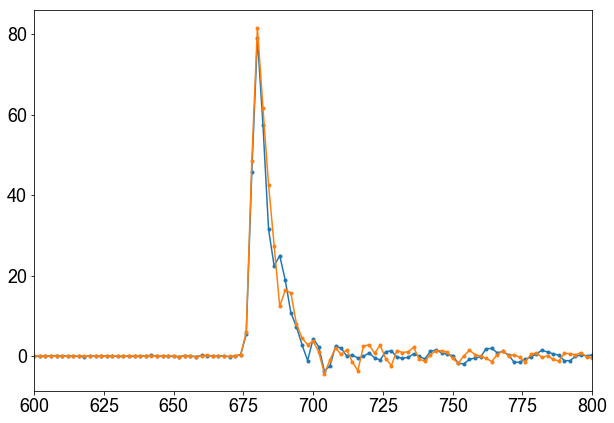

In [13]:
plt.plot(t, pulse_ch0, marker='.')
plt.plot(t, pulse_ch1, marker='.')
plt.xlim(600, 800)

### A New Pulse Shape Model

(-0.05, 1.1)

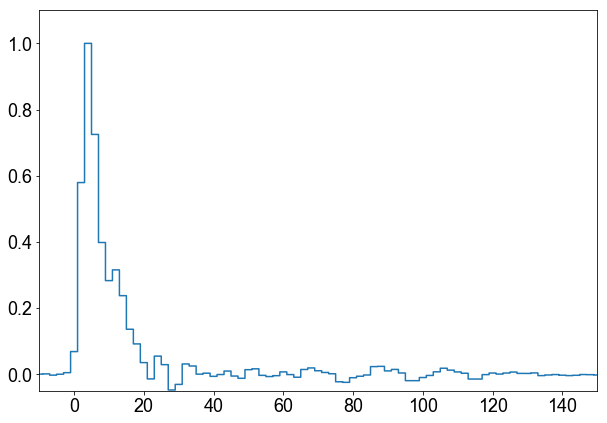

In [18]:
plt.plot(t-675, pulse_ch0 / np.max(pulse_ch0), ls='steps')
plt.xlim(-10, 150)
plt.ylim(-0.05, 1.1)

# def f_osc(t, A, tau, offset):
#     return A * np.sin(2 * np.pi * ((t - offset)/tau))

# t_p = np.linspace(-20, 200, 400)
# plt.plot(t_p, f_osc(t_p, 1.5, 20, 3))

In [33]:
# from scipy.stats import exponnorm

In [64]:
def exp_mod_gaus(tmin, tmax, tstep, tau, sigma, smearing_sigmas=3,  t0=0):
    '''Give a generous array for t'''
    t = np.arange(tmin, tmax, tstep)
    y_unsmeared = exp(t, tau, t0)
    
    # Maximum number of samples to go left or right
    smear_cutoff = int(np.ceil((smearing_sigmas * sigma) / tstep))
    y_arr = np.array([gaus(i * tstep, sigma) * shift_samples(y_unsmeared, i) for i in range(-smear_cutoff, smear_cutoff)])
#     for y in y_arr:
#         plt.plot(t, y)
    y = np.sum(y_arr, axis=0)
    y = y / np.sum(y) / tstep 
    
    return y
    
def exp(t, tau, t0):
    return (t >= t0) * np.exp(-(t - t0)/(tau))

def gaus(x, sigma):
    return np.exp(-0.5 * (x / sigma)**2)

def shift_samples(y, nsamples):
    '''
    Shift samples to the right (negative means left)
    '''
    if nsamples == 0:
        return y
    elif nsamples > 0:
        return np.concatenate([np.zeros(nsamples), y[:-nsamples]])
    elif nsamples < 0:
        return np.concatenate([y[ - nsamples:], np.zeros(-nsamples)])

def rebin(y, nsamples):
    if len(y) % nsamples != 0:
        raise ValueError('No es possibile')
    nbins = int(len(y) / nsamples)
    return np.average(np.reshape(y, (nbins, nsamples)), axis=1)


def average_rebinned_function(tmin, tmax, tstep, tau, sigma, t0_base):
    t0_steps = np.linspace(0, 2, 2/tstep + 1)
    ys = [exp_mod_gaus(tmin, tmax, tstep, tau, sigma, smearing_sigmas = 3, t0 = t0 + t0_base) for t0 in t0_steps]
    ys_rebin = np.array([rebin(y, nsamples = int(2/tstep)) for y in ys])
    # HERE A STEP TO ALIGN!
    max_bin_indices = np.array([np.argmax(y) for y in ys_rebin])
    # Shift such that first one is zero shift
    shift_array = - (max_bin_indices - max_bin_indices[0])
    ys_rebin = np.array([shift_samples(y, i) for y, i in zip(ys_rebin, shift_array)])
    max_bin_indices = np.array([np.argmax(y) for y in ys_rebin])

    y = np.average(ys_rebin, axis=0)
    return y

In [65]:
t_course = np.arange(-20, 200, 2)

p_ch0 = pulse_ch0
p_ch0 = p_ch0[339-10 : 339 + 100]
p_ch0 = p_ch0 / np.sum(p_ch0) / 2 # normalize

p_ch1 = pulse_ch1
p_ch1 = p_ch1[339-10 : 339 + 100]
p_ch1 = p_ch1 / np.sum(p_ch1) / 2 # normalize

In [66]:
def fit(tau, sigma, t0_base, ch, fit_range):
    if tau < 0 or sigma < 0:
        return 1e9
    t_course = np.arange(-20, 200, 2)
    sel = (t_course >= fit_range[0]) & (t_course < fit_range[1])


    y_model = average_rebinned_function(-20, 200, 0.2, tau = tau, sigma = sigma, t0_base = t0_base)
    if ch ==0:
        y_data = p_ch0
    elif ch==1:
        y_data = p_ch1
    else:
        raise ValueError
    
    y_model = y_model[sel]
    y_data = y_data[sel]
    
    diff = np.abs(y_model - y_data)
    return sum(diff**2)
    


In [73]:
def fit_single_channel(ch, fit_range=(-10, 80)):   
    result = scipy.optimize.minimize(lambda x: fit(x[0], x[1], x[2], ch=ch, fit_range = fit_range),
        [6, 2, 0],
        options=dict(maxfev=1000),
        method='Powell')

    # Print the optimization result
    print(result)
    tau, sigma, t0 = result.x

    y = average_rebinned_function(-20, 200, 0.1, tau, sigma, t0)
    plt.plot(t_course, y, ls='steps', label='Model')
    print(ch)
    if ch == 0:
        plt.plot(t_course, p_ch0, ls='steps', label='Data')
    elif ch == 1:
        plt.plot(t_course, p_ch1, ls='steps', label='Data')
    for _l in fit_range:
        plt.axvline(_l)
    plt.xlim(-20, 100)

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 0.00046579387656550339
 message: 'Optimization terminated successfully.'
    nfev: 264
     nit: 5
  status: 0
 success: True
       x: array([ 5.37865973,  1.00568706,  0.74921168])
0


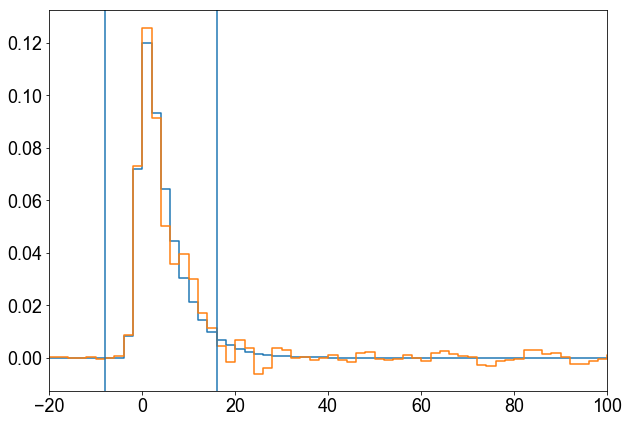

In [74]:
fit_single_channel(0, fit_range=(-8, 16))

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 0.00047868957498342727
 message: 'Optimization terminated successfully.'
    nfev: 257
     nit: 5
  status: 0
 success: True
       x: array([ 5.39382313,  1.00293575,  0.96740569])
1


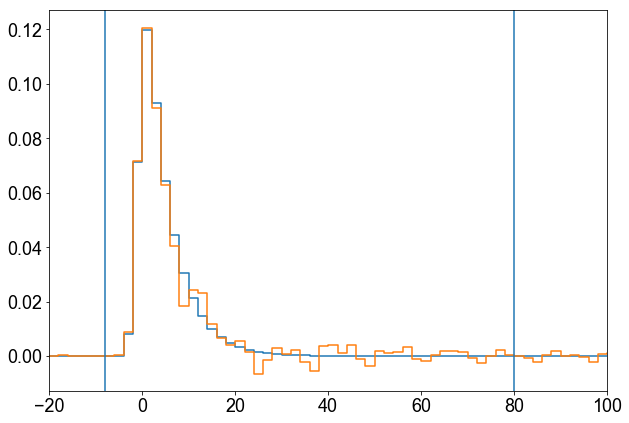

In [75]:
fit_single_channel(1, fit_range=(-8, 80))

### Pretty plot

In [76]:
avg_rebin = average_rebinned_function(-10, 200, 0.2, 5.28139921,  1.02377113,  0.84147311)

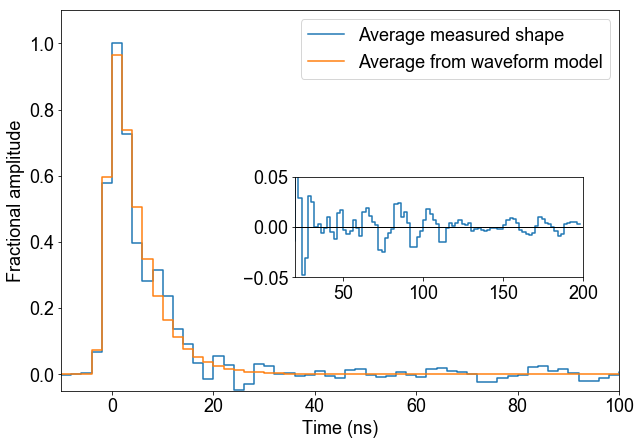

In [90]:
factor1 = 1 / np.sum(p_ch0)
factor2 = 1 / np.sum(avg_rebin)
factor = 1 / (max(factor1 * p_ch0))
plt.plot(t_course, factor * factor1 * p_ch0, ls='steps', label='Average measured shape')
plt.plot(np.arange(-10, 200, 2) , factor * factor2 * avg_rebin , ls='steps', label='Average from waveform model')
plt.xlim(-10, 100)
plt.ylim(-0.05, 1.1)
plt.xlabel('Time (ns)')
plt.ylabel('Fractional amplitude')
plt.legend()
plt.axes([.45, .35, .4, .2])
plt.xlim(20, 200)
plt.plot(t_course, factor * factor1 * p_ch0, ls='steps')
plt.ylim(-0.05, 0.05)
plt.axhline(0, color='black', lw=1)
plt.savefig('/home/erik/win/notes/single_e_waveform.pdf', bbox_inches='tight')
plt.show()

### Area scan

Selected 2876 of 15643 events (18.4 %)
Selected 3270 of 15643 events (20.9 %)
Selected 2970 of 15643 events (19.0 %)
Selected 2348 of 15643 events (15.0 %)
Selected 1668 of 15643 events (10.7 %)
Selected 1142 of 15643 events (7.3 %)
Selected 665 of 15643 events (4.3 %)
Selected 381 of 15643 events (2.4 %)
Selected 210 of 15643 events (1.3 %)
Selected 113 of 15643 events (0.7 %)


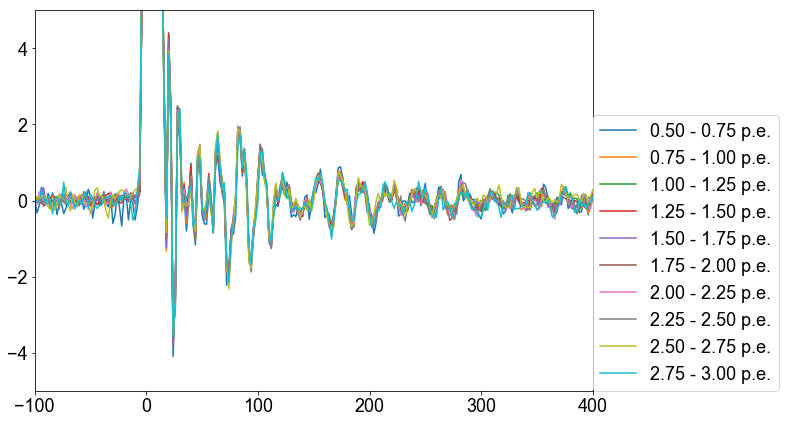

In [26]:
nbins = 11
area_bin_edges = np.linspace(*area_cut_bounds, num=nbins)
for area_min, area_max in zip(area_bin_edges[:-1], area_bin_edges[1:]):
    _x = deepcopy(x)
    _x.cut_area(channel, (area_min, area_max))
    _time, _pulse = _x.get_average_pulse(0, normalize=True, align_on='max_index', alignment_bin=340)
    plt.plot(_time - 340 * 2, _pulse, label='%.2f - %.2f p.e.' % (area_min, area_max))
plt.legend(loc=(1,0))
plt.xlim(-100, 400)
plt.ylim(-5, 5)
plt.show()

### 

### To check out:

  * Per dataset
  * For different area slices (Looks good!)
  * Jackknife?
  * FFT

In [153]:
from IPython.display import display, Javascript
display(Javascript("""
require(
    ["base/js/dialog"], 
    function(dialog) {
        dialog.modal({
            title: 'Hello world',
            body: 'Hi, lorem ipsum and such',
            buttons: {
                'kthxbye': {}
            }
        });
    }
);
"""))

<IPython.core.display.Javascript object>